#### Instalación de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import mapclassify
import geopandas as gpd


#### Importacion de las bases de datos

Los microdatos se consiguen en el siguiente link:
https://microdatos.dane.gov.co/index.php/catalog/DEM-Microdatos

Ahi se descargan las Estadisticas Vitales y se usan los csv's "defunciones no fetales", los cuales fueron guardados en una carpeta llamada Defunciones


Para entender las variables es necesario tener el diccionario. Este mismo lo pueden encontrar en el siguiente link:
https://microdatos.dane.gov.co/index.php/catalog/696/pdf-documentation

In [2]:
df1= pd.read_csv("Defunciones/nofetal2019.csv",encoding="latin1")
df2=pd.read_csv("Defunciones/nofetal2020.csv", encoding="latin1")
df3=pd.read_csv("Defunciones/nofetal2021.csv",encoding="latin1")
df4=pd.read_csv("Defunciones/nofetal2022.csv",encoding="latin1")
df5=pd.read_csv("Defunciones/nofetal2023.csv",encoding="latin1")

#### Selección de variables más importantes

In [3]:
defun19=df1[['COD_DPTO','ANO', 'GRU_ED1', 'EST_CIVIL','SEXO','CAU_HOMOL']]
defun20=df2[['COD_DPTO','ANO', 'GRU_ED1', 'EST_CIVIL','SEXO','CAU_HOMOL']]
defun21=df3[['COD_DPTO','ANO', 'GRU_ED1', 'EST_CIVIL','SEXO','CAU_HOMOL']]
defun22=df4[['COD_DPTO','ANO', 'GRU_ED1', 'EST_CIVIL','SEXO','CAU_HOMOL']]
defun23=df5[['COD_DPTO','ANO', 'GRU_ED1', 'EST_CIVIL','SEXO','CAU_HOMOL']]


#### Concatenacion de los dataframes

In [4]:
defu=pd.concat([defun19,defun20,defun21,defun22,defun23], ignore_index=True)

#### Filtrado
Se filtra por la variable "CAU_HOMOL, el cual hace referencia a la causa básica agrupada con base en la lista 105 Colombia. El codigo 100 hace alusión a la causa "Lesiones autoinfligidas intencionalmente (suicidios) y secuelas"

la tabla de descripcion de los codigos la encuentran en el siguiente link: 
https://www.dane.gov.co/files/investigaciones/poblacion/defunciones/Lista_105_Colombia_CIE9-y-CIE10.xls



In [5]:
sui= defu[defu['CAU_HOMOL']==100]
sui.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15146 entries, 7 to 1463852
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   COD_DPTO   15146 non-null  int64  
 1   ANO        15146 non-null  int64  
 2   GRU_ED1    15146 non-null  int64  
 3   EST_CIVIL  15146 non-null  float64
 4   SEXO       15146 non-null  int64  
 5   CAU_HOMOL  15146 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 828.3 KB


In [6]:
sui

,COD_DPTO,ANO,GRU_ED1,EST_CIVIL,SEXO,CAU_HOMOL
7,25,2019,12,9.0,1,100
15,11,2019,10,5.0,1,100
19,19,2019,14,6.0,1,100
298,52,2019,17,5.0,2,100
487,5,2019,20,6.0,1,100
...,...,...,...,...,...,...
1463615,52,2023,17,1.0,1,100
1463641,25,2023,13,5.0,1,100
1463645,5,2023,12,1.0,1,100
1463657,54,2023,16,6.0,1,100


### Agrupación de suicidios por año y departamento

En este paso se agrupa el total de casos de suicidio por año (`ANO`) y por código de departamento (`COD_DPTO`), utilizando el método `groupby()` seguido de `size()` para contar los registros.

Luego, se renombran las columnas resultantes para mayor claridad:
- `COD_DPTO` se cambia a `DP`
- `ANO` se cambia a `AÑO`

Esto permite tener una tabla resumen con el número de suicidios registrados por departamento y por año, que puede usarse para análisis estadístico o para representar la información gráficamente (por ejemplo, en mapas o series temporales).

In [8]:
tabla= sui.groupby(['ANO','COD_DPTO']).size().reset_index(name="Cantidad")
tabla= tabla.rename(columns={'COD_DPTO':'DP', 'ANO':'AÑO'})
tabla


,AÑO,DP,Cantidad
0,2019,5,477
1,2019,8,79
2,2019,11,432
3,2019,13,78
4,2019,15,77
...,...,...,...
159,2023,91,10
160,2023,94,2
161,2023,95,7
162,2023,97,23


#### Importacion de proyecciones de población DANE

### Proyección de población por departamento - 2019

Se utiliza un archivo de Excel que contiene las proyecciones de población por departamento. El objetivo es extraer únicamente la población total por departamento para el año 2019, que será usada posteriormente para calcular tasas ajustadas de suicidio (por cada 100.000 habitantes).

In [9]:
pob_19=pd.read_excel("Poblaciones/dep_2019.xlsx",skiprows=11)
pob_19= pob_19[(pob_19['AÑO']==2019) & (pob_19["ÁREA GEOGRÁFICA"]=="Total")]
pob_19= pob_19[['DP','AÑO', 'Población']]
pob_19.head()

,DP,AÑO,Población
1388,5,2019,6550206
1391,8,2019,2638151
1394,11,2019,7592871
1397,13,2019,2130512
1400,15,2019,1230910


#### Proyección de población por departamento - 2020 a 2023

Para calcular tasas ajustadas de suicidio en los años más recientes, se utilizan proyecciones oficiales de población por departamento correspondientes a los años 2020, 2021, 2022 y 2023. Los pasos realizados fueron los siguientes:

1. **Carga del archivo**:  
   Se lee el archivo `dep_20_23.xlsx` desde la carpeta `Poblaciones`, ignorando las primeras 11 filas que corresponden a encabezados no estructurados.

2. **Eliminación de valores nulos**:  
   Se descartan registros sin información de población (`pob_20_23["Población"].notna()`), para asegurar la consistencia de los datos.

3. **Conversión de tipos de datos**:  
   Se convierte a tipo entero (`int`) las columnas:
   - `AÑO`: para facilitar filtrado por rango
   - `Población`: para garantizar operaciones numéricas precisas
   - `DP`: código del departamento

4. **Filtrado por criterios relevantes**:  
   Se seleccionan solo los registros donde:
   - El año está entre 2020 y 2023
   - El área geográfica corresponde al total del departamento (`"ÁREA GEOGRÁFICA" == "Total"`)

5. **Selección de columnas finales**:  
   Se conservan únicamente las columnas necesarias para el cálculo de tasas:
   - `DP`: código del departamento
   - `AÑO`: año de referencia
   - `Población`: población proyectada total por departamento

Este DataFrame es fundamental para unir con el conteo de suicidios y calcular tasas por cada 100.000 habitantes.


In [10]:
pob_20_23=pd.read_excel("Poblaciones/dep_20_23.xlsx",skiprows=11)
pob_20_23=df = pob_20_23[pob_20_23["Población"].notna()]
pob_20_23['AÑO']=pob_20_23['AÑO'].astype(int)
pob_20_23['Población']=pob_20_23['Población'].astype(int)
pob_20_23['DP']=pob_20_23['DP'].astype(int)
pob_20_23= pob_20_23[(pob_20_23['AÑO'].between(2020,2023)) & (pob_20_23["ÁREA GEOGRÁFICA"]=="Total")]
pob_20_23= pob_20_23[['DP','AÑO', 'Población']]
pob_20_23

,DP,AÑO,Población
2,5,2020,6649401
5,5,2021,6726219
8,5,2022,6787846
11,5,2023,6848360
65,8,2020,2693665
...,...,...,...
1964,97,2023,46777
2018,99,2020,115196
2021,99,2021,118270
2024,99,2022,120942


### Unificación de proyecciones de población (2019 - 2023)

Una vez procesadas por separado las proyecciones de población del año 2019 (`pob_19`) y las de los años 2020 a 2023 (`pob_20_23`), es necesario combinarlas en un único DataFrame para facilitar su uso posterior en los cálculos de tasas de suicidio por departamento y año.

Se utiliza la función `pd.concat()` con `ignore_index=True` para:
- Unir verticalmente los dos DataFrames (es decir, apilar las filas uno debajo del otro).
- Reiniciar los índices del nuevo DataFrame unificado.

El resultado es una tabla completa con la población proyectada para todos los departamentos colombianos entre 2019 y 2023, lo cual permitirá calcular tasas comparables y consistentes en todo el período analizado.




In [12]:
pob= pd.concat([pob_19,pob_20_23], ignore_index=True)

### Cálculo de la tasa de suicidios por departamento y año

Una vez unificados los datos de población (`pob`) y el conteo de suicidios por departamento y año (`tabla`), se realiza una fusión con `pd.merge()` utilizando un `left join`. Esto garantiza que todos los registros de población se conserven, incluso si no hay registros de suicidios para ese año o departamento.

In [13]:
data=pd.merge(pob,tabla, how="left", on=['AÑO', 'DP'])

In [14]:
#se reemplazan los valores nulos en la columna Cantidad (ausencia de suicidios reportados) por ceros
data['Cantidad']=data['Cantidad'].fillna(0)
# se convierte la columna Cantidad a tipo entero
data['Cantidad']=data['Cantidad'].astype(int)
# se calcula la tasa de suicidio por cada 100.000 habitantes
data['tasa']=round(data['Cantidad']/data['Población']*100000,2)
data

,DP,AÑO,Población,Cantidad,tasa
0,5,2019,6550206,477,7.28
1,8,2019,2638151,79,2.99
2,11,2019,7592871,432,5.69
3,13,2019,2130512,78,3.66
4,15,2019,1230910,77,6.26
...,...,...,...,...,...
160,97,2023,46777,23,49.17
161,99,2020,115196,2,1.74
162,99,2021,118270,3,2.54
163,99,2022,120942,2,1.65


### Cálculo de la tasa promedio de suicidios por departamento (2019–2023)

Para obtener una visión general del comportamiento de los suicidios en el tiempo, se calcula la **tasa promedio** por departamento durante el periodo 2019–2023. Esto permite identificar los territorios con mayor riesgo estructural, más allá de las variaciones anuales.

In [18]:
tasa_promedio=data.groupby('DP')['tasa'].mean().reset_index()
tasa_promedio

,DP,tasa
0,5,7.582
1,8,3.302
2,11,5.508
3,13,3.552
4,15,6.958
5,17,8.706
6,18,5.980
7,19,6.008
8,20,5.960
9,23,4.216


### Mapa

In [15]:
mapa=gpd.read_file("Mapa/MGN_ADM_DPTO_POLITICO.shp")
mapa.head()


,dpto_ccdgo,dpto_cnmbr,dpto_ano_c,dpto_act_a,dpto_narea,dpto_nano,shape_Leng,shape_Area,geometry
0,05,ANTIOQUIA,1886,Constitucion Politica de 1886,62807.004377,2023,21.492797,5.135103,"POLYGON ((-76.41355 8.87383, -76.40465 8.85195..."
1,08,ATLÁNTICO,1910,Ley 21 de 1910,3314.458393,2023,2.571601,0.273823,"POLYGON ((-74.84946 11.09778, -74.84938 11.097..."
2,11,"BOGOTÁ, D.C.",1538,Constitucion Politica de 1886,1622.852980,2023,3.765371,0.132208,"POLYGON ((-74.07059 4.82856, -74.07036 4.82856..."
3,13,BOLÍVAR,1886,Constitucion Politica de 1886,26720.328604,2023,16.273430,2.195669,"MULTIPOLYGON (((-76.17318 9.38785, -76.17287 9..."
4,15,BOYACÁ,1886,Constitucion Politica de 1886,23137.997637,2023,15.906767,1.888387,"POLYGON ((-72.17368 7.05308, -72.17277 7.05224..."


### Preparación del shapefile para el cruce con los datos de suicidios

El shapefile contiene la geometría de los departamentos de Colombia, pero su columna con los códigos departamentales (`dpto_ccdgo`) estaba en formato de texto. Para realizar el cruce con el DataFrame que contiene las tasas de suicidio por departamento, fue necesario:

1. **Convertir la columna `dpto_ccdgo` a tipo numérico**, ya que los códigos en el otro DataFrame (`data`) están como enteros.
2. **Renombrar la columna a `DP`** para que coincida con el nombre usado en los datos de tasas.

```python
mapa['dpto_ccdgo'] = pd.to_numeric(mapa['dpto_ccdgo'])
mapa.rename(columns={'dpto_ccdgo': 'DP'}, inplace=True)


In [16]:
mapa['dpto_ccdgo']=pd.to_numeric(mapa['dpto_ccdgo'])
mapa.rename(columns={'dpto_ccdgo':'DP'}, inplace=True)

### Unión del shapefile con los datos de tasas de suicidio

Una vez que tanto el shapefile como el DataFrame de tasas tienen una columna común (`DP`) y del mismo tipo, se realiza la unión (`merge`) entre ellos. Esto permite incorporar la tasa promedio de suicidios por departamento al shapefile y así poder visualizarla geográficamente.

In [19]:
figura= pd.merge(mapa, tasa_promedio, how="left", on='DP')
figura.head()

,DP,dpto_cnmbr,dpto_ano_c,dpto_act_a,dpto_narea,dpto_nano,shape_Leng,shape_Area,geometry,tasa
0,5,ANTIOQUIA,1886,Constitucion Politica de 1886,62807.004377,2023,21.492797,5.135103,"POLYGON ((-76.41355 8.87383, -76.40465 8.85195...",7.582
1,8,ATLÁNTICO,1910,Ley 21 de 1910,3314.458393,2023,2.571601,0.273823,"POLYGON ((-74.84946 11.09778, -74.84938 11.097...",3.302
2,11,"BOGOTÁ, D.C.",1538,Constitucion Politica de 1886,1622.852980,2023,3.765371,0.132208,"POLYGON ((-74.07059 4.82856, -74.07036 4.82856...",5.508
3,13,BOLÍVAR,1886,Constitucion Politica de 1886,26720.328604,2023,16.273430,2.195669,"MULTIPOLYGON (((-76.17318 9.38785, -76.17287 9...",3.552
4,15,BOYACÁ,1886,Constitucion Politica de 1886,23137.997637,2023,15.906767,1.888387,"POLYGON ((-72.17368 7.05308, -72.17277 7.05224...",6.958


### Mapa Corropletico

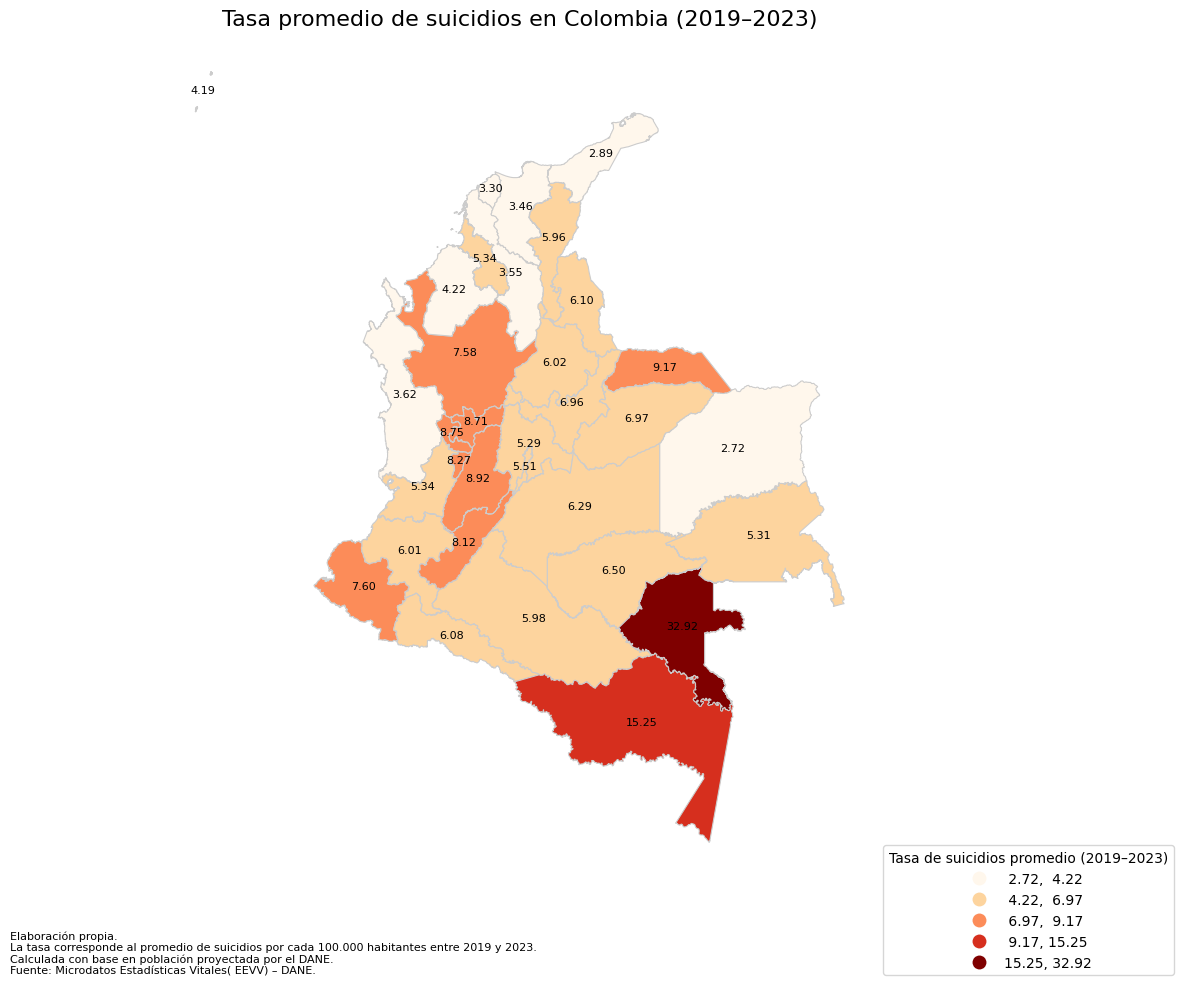

In [22]:


classifier = mapclassify.NaturalBreaks(figura['tasa'], k=5)

fig, ax = plt.subplots(figsize=(12, 10))


figura.plot(
    column='tasa',
    cmap='OrRd',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    scheme='natural_breaks',
    k=5,
    legend_kwds={
        'title': 'Tasa de suicidios promedio (2019–2023)',
        'loc': 'upper left',
    'bbox_to_anchor': (1, 0.05),
    'fontsize': 10
    },
    ax=ax
)

for idx, row in figura.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        centroid = row['geometry'].centroid
    else:
        centroid = row['geometry'].centroid

    tasa_texto = f"{row['tasa']:.2f}"
    ax.text(centroid.x, centroid.y, tasa_texto, fontsize=8, ha='center', color='black')

ax.set_title("Tasa promedio de suicidios en Colombia (2019–2023)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.figtext(0.01, 0.02,
            "Elaboración propia.\n"
            "La tasa corresponde al promedio de suicidios por cada 100.000 habitantes entre 2019 y 2023.\n"
            "Calculada con base en población proyectada por el DANE.\n"
            "Fuente: Microdatos Estadísticas Vitales( EEVV) – DANE.",
            ha='left', fontsize=8)

plt.show()



#### Guardar como png en alta resolución

In [23]:
fig.savefig("tasa_suicidios_colombia_2019_2023.png",
            dpi=300,              
            bbox_inches='tight')    